In [2]:
import numpy as np
import copy
import itertools

DATASPACING = 4
alpha = 0.01

ISINPUTNEURON = 1
ISOUTPUTNEURON = 2


class nWeb:
    def __init__(self,dimensions, inputDims): #dimensions should be a tuple of lengths
        self.dimensions = dimensions
        self.nodesPerNeuron = int(len(dimensions) * 2)
        self.inputDims = inputDims
        if self.inputDims >= len(self.dimensions):
            error("input dims and dimensions not compatible")
        self.state = np.zeros(dimensions + (self.nodesPerNeuron,), dtype='float32')
        self.prevState = copy.deepcopy(self.state)
        self.biases = copy.deepcopy(self.state)
        
        self.weightsPerNeuron = self.nodesPerNeuron * (self.nodesPerNeuron - 1)
#         self.weights = np.random.randn(*(dimensions + (self.nodesPerNeuron, self.nodesPerNeuron - 1))).astype('float32')
        self.weights = np.ones(dimensions + (self.nodesPerNeuron, self.nodesPerNeuron - 1), dtype = 'float32')
        
    def _checkNeuronType(self, ne):
        if list(ne)[self.inputDims:] == [0] * (len(self.dimensions) - self.inputDims):
            return ISINPUTNEURON
        elif list(ne)[self.inputDims:] == [x - 1 for x in list(self.dimensions)[self.inputDims:]]:
            return ISOUTPUTNEURON
        else:
            return 0
    
    def _getNeurons(self):
        return itertools.product(*map(range, list(self.dimensions)))
    
    def step(self, firstDimIns, firstDimOuts, train = True):
        #"in" and "out" is arbitrary, given that it learns both ways
        neurons = self._getNeurons()
        #get activations
        for neuron in neurons:            
                     
#             print neuron
            activations = self.state[neuron]

            cycledactivations = np.tile(activations, 2)

            new = np.zeros((self.nodesPerNeuron), dtype = 'float32')
            self.prevState[neuron] = self.state[neuron][:]
            
            for i in range(self.nodesPerNeuron):
#                 print self.weights[neuron][i]
#                 print cycledactivations[i:i + self.nodesPerNeuron - 1]
                new[i] = np.dot(self.weights[neuron][i], cycledactivations[i + 1:i + self.nodesPerNeuron])
                new[i] = np.tanh(new[i] + self.biases[neuron + (i,)])
            
            self.state[neuron] = new[:]
        #train
        if train:
            neurons = self._getNeurons()

            for neuron in neurons:
                
                flag = self._checkNeuronType(neuron)
                isInputNeuron = flag == ISINPUTNEURON
                isOutputNeuron = flag == ISOUTPUTNEURON
                
                #get adjacent neurons. Note that only one dimension is changing at a time
                adjacents = []
                for i in range(len(neuron)):
                    temp = list(neuron)[:]
                    temp[i] += 1

                    if temp[i] > self.dimensions[i] - 1:
                        temp[i] = 0
                    elif temp[i] < 0:
                        temp[i] = self.dimensions[i] - 1

                    adjacents.append(tuple(temp[:]))
                    temp[i] -= 2

                    if temp[i] > self.dimensions[i] - 1:
                        temp[i] = 0
                    elif temp[i] < 0:
                        temp[i] = self.dimensions[i] + temp[i]

                    adjacents.append(tuple(temp[:]))

#                 print adjacents
                
                others = []
                for i in range(len(adjacents)):
                    x = i
                    if i % 2 == 0:
                        x += 1
                    else:
                        x -= 1

#                     print x
                    
                    if i == 3 and isInputNeuron:
                        others.append(firstDimIns[neuron[0]])
                    elif i == 2 and isOutputNeuron:
                        others.append(firstDimOuts[neuron[0]])
                    else:
                        others.append(self.state[adjacents[i]][x])


                dEdOuts = self.state[neuron] - np.array(others)
                dOutsdIns = np.ones_like(self.state[neuron]) - (self.state[neuron] * self.state[neuron])
                dEdIns = dEdOuts * dOutsdIns
                self.biases[neuron] -= alpha * dEdIns
                cycledActivations = np.tile(self.prevState[neuron], 2)
                expandeddEdIns = np.repeat(dEdIns , self.nodesPerNeuron - 1)

#                 print cycledActivations
#                 print type(self.nodesPerNeuron)

                temp = np.array([0,0], dtype='float32')
                for i in range(self.nodesPerNeuron):
#                     print cycledActivations[i:i + self.nodesPerNeuron - 1]
#                     print np.concatenate((temp, cycledActivations[i:i + self.nodesPerNeuron - 1]))
                    temp = np.concatenate((temp, cycledActivations[i + 1:i + self.nodesPerNeuron]))
                temp = temp[2:]
#                 print temp.shape
#                 print expandeddEdIns.shape
#                 print self.weights[neuron]
                dEdWs = expandeddEdIns * temp
                self.weights[neuron] -= alpha * dEdWs.reshape((self.nodesPerNeuron, self.nodesPerNeuron -1))

        #rectify the opposing activations
        self.prevState = copy.deepcopy(self.state)
        self.state = np.zeros_like(self.state)
        neurons = self._getNeurons()
        theirIns = np.zeros((self.dimensions[0]), dtype = 'float32')
        theirOuts = copy.deepcopy(theirIns)
        for neuron in neurons:
            
            flag = self._checkNeuronType(neuron)
            isInputNeuron = flag == ISINPUTNEURON
            isOutputNeuron = flag == ISOUTPUTNEURON
            
            adjacents = []
            for i in range(len(neuron)):
                temp = list(neuron)[:]
                temp[i] += 1

                if temp[i] > self.dimensions[i] - 1:
                    temp[i] = 0
                elif temp[i] < 0:
                    temp[i] = self.dimensions[i] + temp[i]

                adjacents.append(tuple(temp[:]))

#             print "adjacents: " + str(adjacents)
            for i in range(len(adjacents)):
                
                x = 2 * i + 1
                j = 2 * i
                
                
                # if self.prevState[neuron][i] != 1.0 and self.prevState[adjacents[i]][x] != 1.0:
                if i == 1 and isOutputNeuron:
                    theirOuts[neuron[0]] = self.prevState[neuron][j]
                    self.state[neuron][j] = firstDimOuts[neuron[0]]
                else:
                    diff = self.prevState[neuron][j] - self.prevState[adjacents[i]][x]
                    if diff >= 0.0:
                        self.state[adjacents[i]][x] = diff
                        self.state[neuron][j] = 0.0
                    else:
                        self.state[adjacents[i]][x] = 0.0
                        self.state[neuron][j] = abs(diff)
            
            if isInputNeuron:
                theirIns[neuron[0]] = self.prevState[neuron][3] #check these numbers
                self.state[neuron][3] = firstDimIns[neuron[0]]
        
        return theirIns, theirOuts
    
    def clearMemory(self):
        self.state = np.zeros_like(self.state)
            
                        
#     def setInsOuts(self, inDims, ins, outDims, outs):
#         inPadding = [self.dimensions[inDims[i]] - (DATASPACING * (ins[i].size - 1) + 1) for i in range(len(ins))]
#         outPadding = [self.dimensions[outDims[i]] - (DATASPACING * (outs[i].size - 1) + 1) for i in range(len(outs))]
#         for j in range(len(inDims)):
#             nodePosition = (inDims[j] - 1) * 2
#             for i in range(len(ins[j])):
#                 ind = [0] * len(self.dimensions)
#                 ind[inDims[j] - 1] = i * DATASPACING
#                 ind = tuple(ind + [nodePosition])
#                 self.state[ind] = ins[j][i]
                
#         for j in range(len(outDims)):
#             nodePosition = (outDims[j] - 1) * 2 + 1
#             for i in range(len(outs[j])):
#                 ind = [0] * len(self.dimensions)
#                 ind[outDims[j] - 1] = i * DATASPACING
#                 ind = tupe(ind + [nodePosition])
#                 self.state[ind] = ins[j][i]



In [5]:
import matplotlib.pyplot as plt
import numpy as np

def toFlattened(s):
    flattendState = np.zeros((s.shape[0] * 3, s.shape[1] * 3))
    for i in range(s.shape[0]):
        for j in range(s.shape[1]):
            frame = np.zeros((3,3))
            frame[2][1] = s[i][j][0]
            frame[0][1] = s[i][j][1]
            frame[1][0] = s[i][j][3]
            frame[1][2] = s[i][j][2]
            
            for x in range(3):
                for y in range(3):
                    flattendState[i *3 +x ][j * 3 + y] = frame[x][y]
    return flattendState

def graphState(aState): #only works for 2D
    
    
#     column_labels = map(str, range(s.shape[1]))
#     row_labels = map(str, range(s.shape[0]))
    data = toFlattened(aState)
    
    fig, ax = plt.subplots()
    heatmap = ax.pcolor(data)
#     ax.set_xticks(np.arange(s.shape[0]) * 3.0 + 1.5, minor = False)
#     ax.set_yticks(np.arange(s.shape[1]) * 3.0 + 1.5, minor = False)

    plt.show()

    
    
    

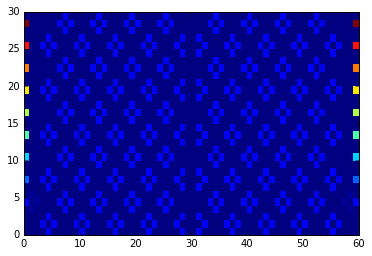

In [42]:
%matplotlib inline
x = np.arange(10).astype('float32')
# myWeb = nWeb((10,20),1)
# myWeb.biases = np.random.rand(*myWeb.biases.shape) * 0.1
# myWeb.weights = np.random.randn(*myWeb.weights.shape)
myWeb.step(x,x)
# print myWeb.state 
# print myWeb.weights
graphState(myWeb.state)


In [10]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
# %matplotlib notebook

myWeb = nWeb((10,20))
myWeb.biases = np.random.rand(*myWeb.biases.shape) * 0.1
myWeb.weights = np.random.randn(*myWeb.weights.shape)
stepsPerExample = sum(myWeb.dimensions) * 2

# fig = plt.figure(figsize = (12,24))
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.imshow(toFlattened(myWeb.state[:]))
plt.show(block=False)
trainin = [np.arange(10).astype('float32')] * 10
trainout = copy.deepcopy(trainin)
def init():
    im.set_data(toFlattened(myWeb.state[:]))
    return (im,)

def animate(i):
    index = i // stepsPerExample
    myWeb.step(trainin[index][:],trainout[index][:])
    dat = toFlattened(myWeb.state[:])[:]
    im.set_data(dat)
    return im,

anim = animation.FuncAnimation(fig, animate, interval = 250, init_func = init, frames = len(trainin) * stepsPerExample, blit=True)

HTML(anim.to_html5_video())
    
    
    

TypeError: __init__() takes exactly 3 arguments (2 given)

In [31]:
from ale_python_interface import ALEInterface
import numpy as np

romFileName = "AtariRoms/Ms-Pacman"

ale = ALEInterface()

max_frames_per_episode = ale.getInt("max_num_frames_per_episode");
ale.set("random_seed",123)

random_seed = ale.getInt("random_seed")
print("random_seed: " + str(random_seed))

ale.loadROM(romFileName)
legal_actions = ale.getLegalActionSet()

for episode in range(10):
    total_reward = 0.0 
    while not ale.game_over():
        a = legal_actions[np.random.randint(legal_actions.size)]
        reward = ale.act(a);
        total_reward += reward
    print("Episode " + str(episode) + " ended with score: " + str(total_reward))
    ale.reset_game()


[1, 2, 3]

In [33]:
np.ones((2,3))

array([[ 1.,  1.,  1.],
       [ 1.,  1.,  1.]])

<IPython.core.display.Javascript object>


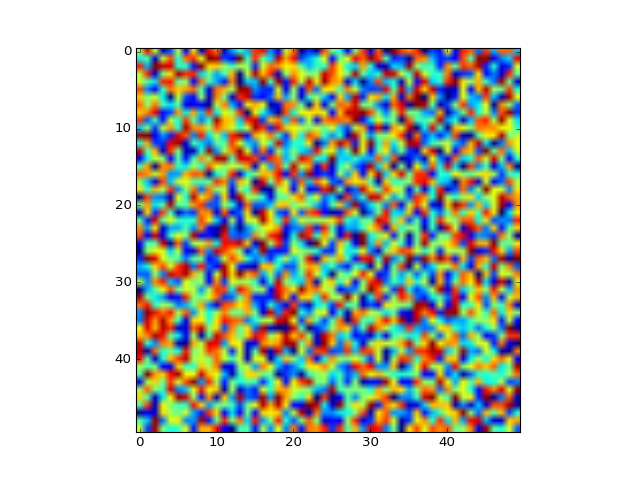

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
%matplotlib notebook
# create the figure
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.imshow(np.random.random((50,50)))
plt.show(block=False)

# draw some data in loop
for i in range(10):
    # wait for a second
    time.sleep(1)
    # replace the image contents
    im.set_array(np.random.random((50,50)))
    # redraw the figure
    fig.canvas.draw()